### notebook shared by Gabrielle on wet vegetation masking
-backed up as useful for 2021 when wet veg gets included due to collection upgrate

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from datacube.utils import cog
import glob
import re
import rasterio

In [5]:
def get_koppen_tile(da):
    koppen = rasterio.open(
        "/g/data/r78/ma6611/Beck_KG_V1_present_0p0083.tif"
    )  # 1km resolution
    dest = np.zeros(da.shape)
    src_transform = koppen.transform
    koppen_tile = rasterio.warp.reproject(
        koppen.read(),
        dest,
        src_crs=koppen.crs,
        dst_crs="EPSG:3577",
        src_transform=src_transform,
        dst_transform=da.transform,
    )
    return koppen_tile[0].astype(int)

In [6]:
extra_tiles = [
    '-10_-36','11_-40','12_-48','-13_-27','14_-41','15_-22','-15_-36','16_-34','16_-39',
    '20_-32','3_-35','5_-30','5_-38','6_-39','6_-40','8_-20','8_-28','9_-36',
    '12_-47','14_-35','3_-14','0_-13','8_-31','17_-39','14_-23'
]

test_tiles = ['14_-23']

14_-23
wet_masked <xarray.DataArray (y: 4000, x: 4000)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)
Coordinates:
    band     int64 4
  * y        (y) float64 -2.2e+06 -2.2e+06 -2.2e+06 ... -2.3e+06 -2.3e+06
  * x        (x) float64 1.4e+06 1.4e+06 1.4e+06 ... 1.5e+06 1.5e+06 1.5e+06
Attributes:
    transform:      (25.0, 0.0, 1400000.0, 0.0, -25.0, -2200000.0)
    crs:            +init=epsg:3577
    res:            (25.0, 25.0)
    is_tiled:       1
    nodatavals:     (-9999.0, -9999.0, -9999.0, -9999.0)
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area
    created:        {'lineage': {'algorithm': {'name': 'datacube-stats', 'ver...
unique [0 1]


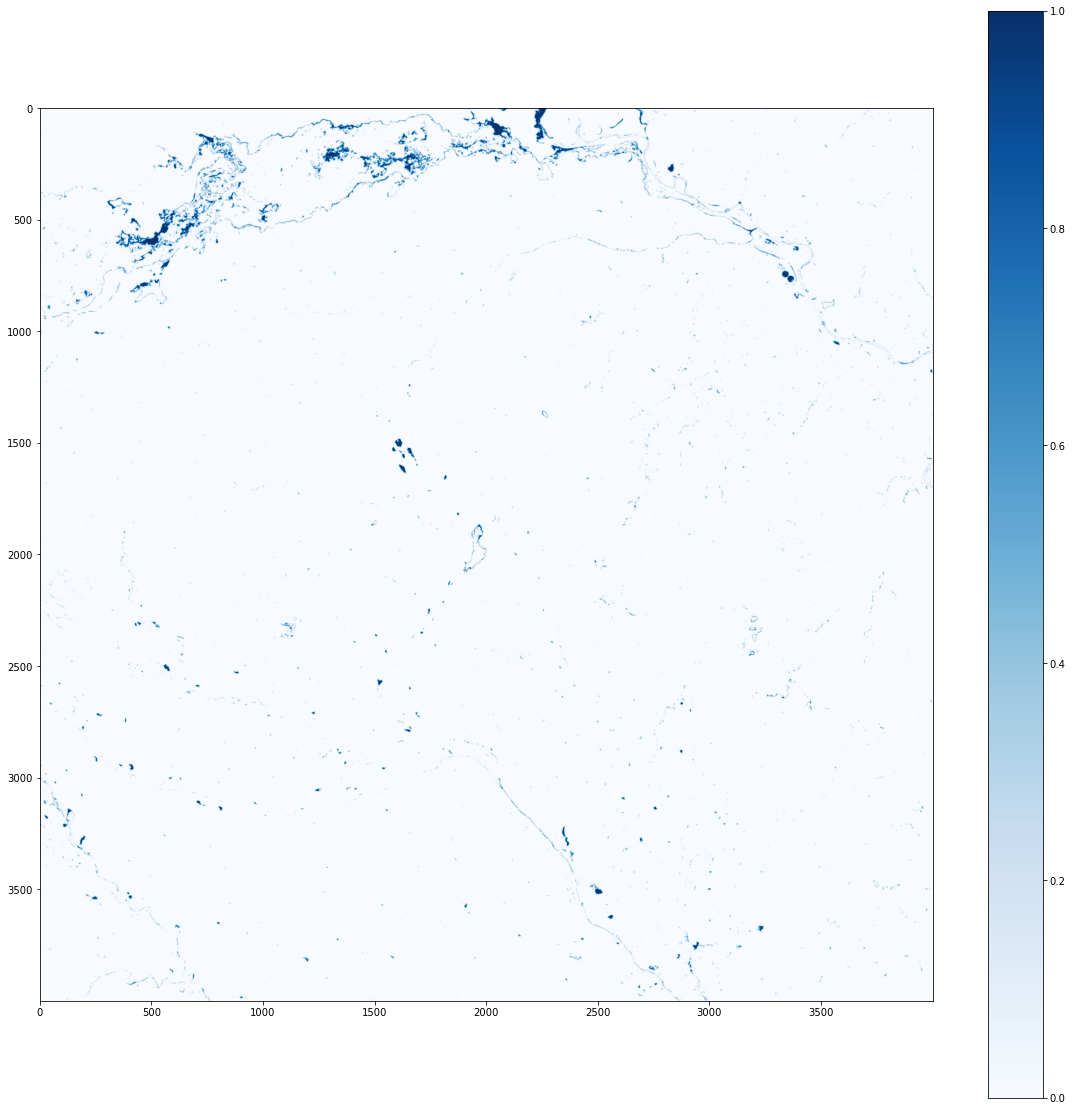

In [10]:
# Folder where the tiles are
tile_folder = '/g/data/r78/datacube_stats/TCW_stats/demo_tiles/gabrielle_workspace/output/'

# Grab a list of all of the tif files in the tile folder
tif_files = glob.glob(f"{tile_folder}*.tif")
tif_files

# for tile in tile_list:
#     tcw = glob.glob(f'{new_folder}LS_TCW_PC_{tile}_1986_2020_summary.tif')
#     print(tcw)
    
# for files in tif_files:
for tile in test_tiles:
    
    print(tile)
    
    # Load MrVBF data
    mrvbf_folder = '/g/data/u46/wofs/confidence_albers/MrVBF/tiles/'
    mrvbf = xr.open_dataset(f'{mrvbf_folder}mrvbf_{tile}.nc')
    low = mrvbf.band1.isel(time=0) >= 3 # low and flat areas
    high = mrvbf.band1.isel(time=0) < 3 # high and steep areas

    # Load TCW and TCG
    tcw = xr.open_rasterio(f'{tile_folder}LS_TCW_PC_{tile}_1986_2020_summary.tif')
    tcg = xr.open_rasterio(f'{tile_folder}LS_TCG_PC_{tile}_1986_2020_summary.tif')

    # Load koppen data (based on any of the TC tiles)
    koppen = get_koppen_tile(tcw.isel(band=0))
    
    # Select koppen values of interest
    k4 = (koppen == 4) # arid climate
    k7 = (koppen == 7) # irrigated region
    
    # Apply wetness threshold but not open water
    # might be easier to visualise with water then take it out for final run
    wet = (tcw.isel(band=3)>-600) & (tcw.isel(band=3)<0)

    # Apply greenness threshold
    green_high = tcg.isel(band=1)>500 # areas steep and high with dark green forest
    green_low = tcg.isel(band=1)>1000 # EDIT: wetlands in lower areas actually greener than surrounds

    # Mask greenness by mrvbf - binary + nan
    green_high_mrvbf = green_high.where(high == 1)
    green_low_mrvbf = green_low.where(low == 1)

    # Create a crop mask for areas with cropping (currently koppen 7)
    crop_mask_lt = np.where(tcg.isel(band=1)<600,1,0)
    crop_mask_gt = np.where(tcg.isel(band=1)>50,1,0)
    crop_mask = np.where((crop_mask_lt + crop_mask_gt)==2,1,0)

    # Combine into one greenness mask
#     green_combo = np.nansum(np.dstack((green_high_mrvbf, green_low_mrvbf)),2)
    green_combo = np.where((green_high_mrvbf)>=1,1,0)

    # If in arid zone don't have a green mask
    green_combo_mask = np.where(k4 == 1,0,green_combo)

    # Mask wet by greennnes mask
    # wet_masked = wet.where(green_combo_mask != 1)
    wet_masked = wet.where(green_combo_mask != 1,0,0).astype('int32')
    wet_masked.attrs = tcw.attrs
    
    plt.figure(figsize=(20,20))
    plt.imshow(wet_masked,cmap='Blues',interpolation='gaussian')
    plt.colorbar()

    print('wet_masked',wet_masked)
    print('unique',np.unique(wet_masked.data))

#     cog.write_cog(wet_masked,f'Burkedin_test_TCW_gt_600_mask_TCG_gt_500_MrVBF_K4_{tile}.tif')